<a href="https://colab.research.google.com/github/harshitneverdebugs/DeepLearning/blob/master/SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
pip install tensorflow

In [4]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array

from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

In [5]:
df=pd.read_csv("/content/drive/MyDrive/IMDB Dataset.csv")

In [6]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
df.isnull().sum()

,0
review,0
sentiment,0


<Axes: xlabel='sentiment', ylabel='count'>

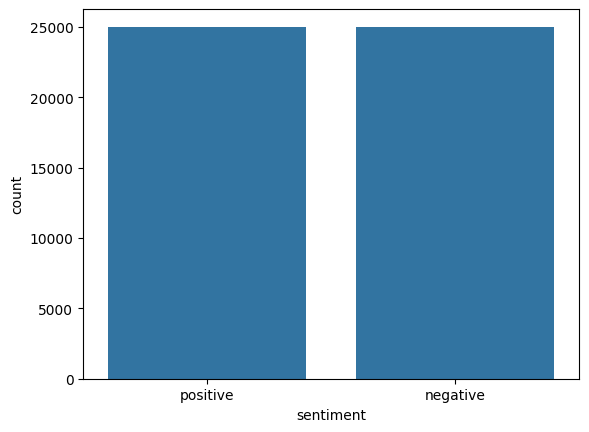

In [8]:
import seaborn as sns
sns.countplot(x='sentiment', data=df)

In [9]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''
    return TAG_RE.sub('', text)

In [10]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
def preprocess_text(sen):

    sentence = sen.lower()
    sentence = remove_tags(sentence)
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    sentence = re.sub(r'\s+', ' ', sentence)

    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence


In [13]:
X=[]
sentences=list(df['review'])
for sen in sentences:
  X.append(preprocess_text(sen))

In [14]:
X[5]

'probably time favorite movie story selflessness sacrifice dedication noble cause preachy boring never gets old despite seen times last years paul lukas performance brings tears eyes bette davis one truly sympathetic roles delight kids grandma says like dressed midgets children makes fun watch mother slow awakening happening world roof believable startling dozen thumbs movie '

In [28]:
Y = df['sentiment']
Y = np.array(list(map(lambda x: 1 if x=="positive" else 0, Y)))

In [29]:
X_train, X_test, Y_train, Y_test=train_test_split(X,Y, test_size=0.2, random_state=42)

In [30]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [31]:
vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

92394

In [33]:
maxlen=100
X_train=pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test=pad_sequences(X_test, padding='post', maxlen=maxlen)

In [43]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2024-09-30 04:05:19--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-09-30 04:05:19--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-09-30 04:05:20--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [44]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [45]:
!ls
!pwd

drive		   glove.6B.200d.txt  glove.6B.50d.txt	sample_data
glove.6B.100d.txt  glove.6B.300d.txt  glove.6B.zip
/content


In [48]:
from numpy import asarray
from numpy import zeros
embeddings_dictionary=dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
  records=line.split()
  word=records[0]
  vector_dimensions=asarray(records[1:], dtype='float32')
  embeddings_dictionary[word]=vector_dimensions
glove_file.close()

In [49]:
embedding_matrix=zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
  embedding_vector=embeddings_dictionary.get(word)
  if embedding_vector is not None:
    embedding_matrix[index]=embedding_vector

In [50]:
embedding_matrix.shape

(92394, 100)

Simple Neural Network

In [56]:
snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
snn_model.add(embedding_layer)
snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

In [57]:
snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(snn_model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │       9,239,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,239,400 (35.25 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,239,400 (35.25 MB)

None


In [60]:
snn_model_history=snn_model.fit(X_train, Y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - acc: 0.6762 - loss: 0.5957 - val_acc: 0.7598 - val_loss: 0.4998
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - acc: 0.7998 - loss: 0.4433 - val_acc: 0.7559 - val_loss: 0.5106
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - acc: 0.8250 - loss: 0.4010 - val_acc: 0.7601 - val_loss: 0.5077
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - acc: 0.8367 - loss: 0.3784 - val_acc: 0.7632 - val_loss: 0.5081
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.8467 - loss: 0.3617 - val_acc: 0.7567 - val_loss: 0.5279
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.8504 - loss: 0.3502 - val_acc: 0.7476 - val_loss: 0.5549


In [61]:
score=snn_model.evaluate(X_test, Y_test, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7386 - loss: 0.5740


In [62]:
print("Test score:", score[0])
print("Test accuracy:", score[1])

Test score: 0.5776106715202332
Test accuracy: 0.7398999929428101


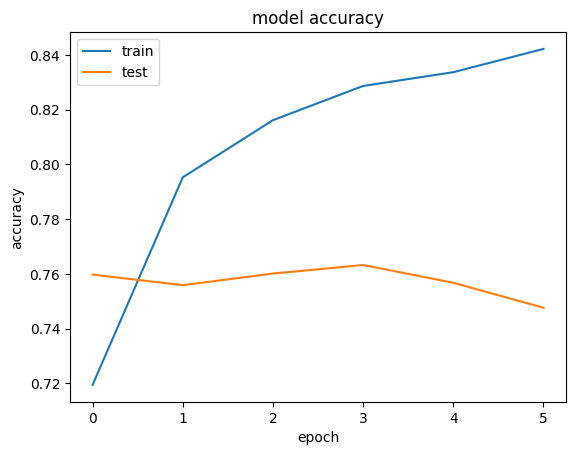

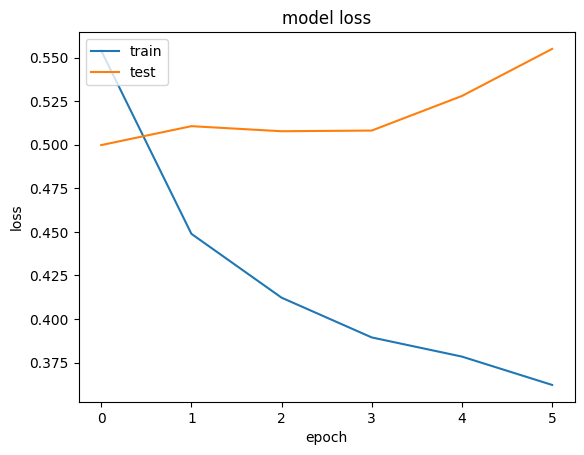

In [63]:
import matplotlib.pyplot as plt

plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

Convolutional Neural Network

In [64]:
from keras.layers import Conv1D

In [65]:
cnn_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)
cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [66]:
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │       9,239,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,239,400 (35.25 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,239,400 (35.25 MB)

None


In [72]:
cnn_model_history = cnn_model.fit(X_train, Y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 30s 118ms/step - acc: 0.7109 - loss: 0.5491 - val_acc: 0.8328 - val_loss: 0.3800
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 32s 128ms/step - acc: 0.8559 - loss: 0.3385 - val_acc: 0.8479 - val_loss: 0.3476
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 39s 119ms/step - acc: 0.8894 - loss: 0.2820 - val_acc: 0.8533 - val_loss: 0.3345
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 44s 131ms/step - acc: 0.9175 - loss: 0.2350 - val_acc: 0.8550 - val_loss: 0.3321
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 29s 116ms/step - acc: 0.9387 - loss: 0.1944 - val_acc: 0.8583 - val_loss: 0.3319
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 43s 124ms/step - acc: 0.9575 - loss: 0.1585 - val_acc: 0.8559 - val_loss: 0.3391


In [73]:
score = cnn_model.evaluate(X_test, Y_test, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - acc: 0.8568 - loss: 0.3364


In [74]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.34147876501083374
Test Accuracy: 0.853600025177002


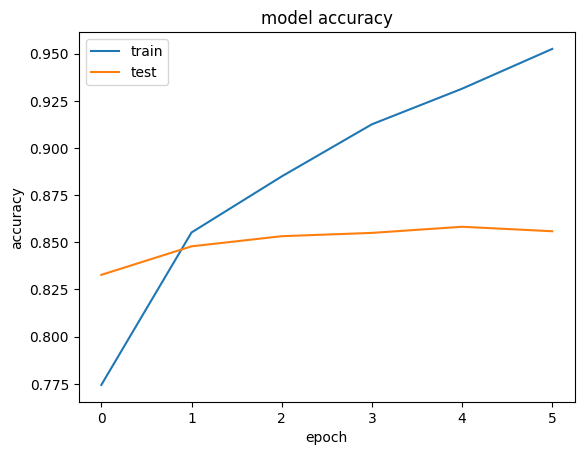

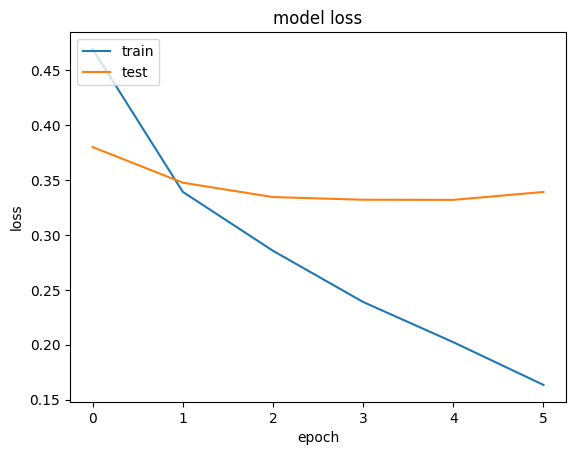

In [75]:
import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

Reccurent Neural Network(LSTM)

In [76]:
lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))
lstm_model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [77]:
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │       9,239,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,239,400 (35.25 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,239,400 (35.25 MB)

None


In [79]:
lstm_model_history = lstm_model.fit(X_train, Y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 105s 414ms/step - acc: 0.6760 - loss: 0.5768 - val_acc: 0.8027 - val_loss: 0.4559
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 144s 423ms/step - acc: 0.8031 - loss: 0.4370 - val_acc: 0.8256 - val_loss: 0.3922
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 106s 425ms/step - acc: 0.8326 - loss: 0.3813 - val_acc: 0.8375 - val_loss: 0.3761
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 145s 438ms/step - acc: 0.8472 - loss: 0.3567 - val_acc: 0.8566 - val_loss: 0.3431
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 128s 380ms/step - acc: 0.8658 - loss: 0.3189 - val_acc: 0.8521 - val_loss: 0.4057
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 141s 378ms/step - acc: 0.8673 - loss: 0.3138 - val_acc: 0.8531 - val_loss: 0.3328


In [81]:
score = lstm_model.evaluate(X_test, Y_test, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 69ms/step - acc: 0.8576 - loss: 0.3323


In [82]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.33251845836639404
Test Accuracy: 0.8550000190734863


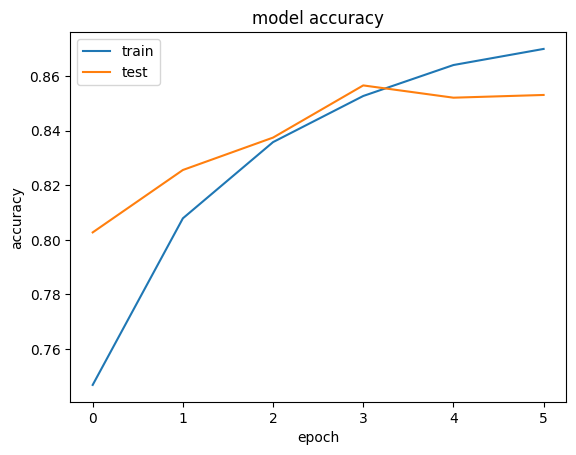

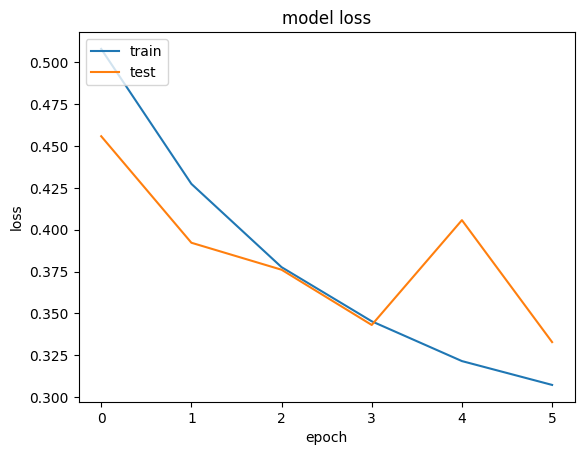

In [83]:
import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()